In [1]:
from ma.utils.utils import Tol#, dim_annotation
import ma.bolted_joint.washers as washers
import ma.bolted_joint.fasteners as fasteners #import NAS1352048
from ma.materials.isotropic import Al6061T6_sheet
from ma.bolted_joint.components import TappedJoint, JointMember
from ma.bolted_joint.JointReport import JointReport

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
washer = washers.NAS1149DN416x
washer2 = washers.NAS1149DN432x

bracket = JointMember(
        description='Bracket',
        material=Al6061T6_sheet,
        thickness=Tol(nom=0.08,min_tol=0.001,max_tol=0.005),
        kind='clearance',
        D_c=0.12,
        width=0.4,
        D_cs=.17,
        # D_cs=None,
        angle_cs=120.)

bracket1 = JointMember(
        description='Bracket 2',
        material=Al6061T6_sheet,
        thickness=Tol(0.15,eq=0.01),
        kind='clearance',
        D_c=0.14,
        width=0.75,
        )

baseplate = JointMember(
        description='Baseplate',
        material=Al6061T6_sheet,
        thickness=Tol(0.60, eq=0.03),
        kind='tapped',
        D_c=0.089, # TODO - this should be a lookup
        # hole_depth='thru',
        hole_depth=0.48, 
        tap_depth=.3,
        D_cs=.150,
        angle_cs=120)

j1000 = TappedJoint(fastener=fasteners.NAS1352048, 
                T=Tol(nom=9., min_tol=0.5, max_tol=0.5),
                K=0.2,
                G=0.35,
                washers=[washer, washer2], 
                members=[bracket, bracket1, baseplate],
                margins=['SF'],
                name='Top bracket to Baseplate',
                description='Trade 2. Ref dwg 324231, rev A.',
                )
# j1000.plot()

## Plot min and max engagement 

array([<Axes: title={'center': 'Minimum clearance'}>,
       <Axes: title={'center': 'Minimum engagement'}>], dtype=object)

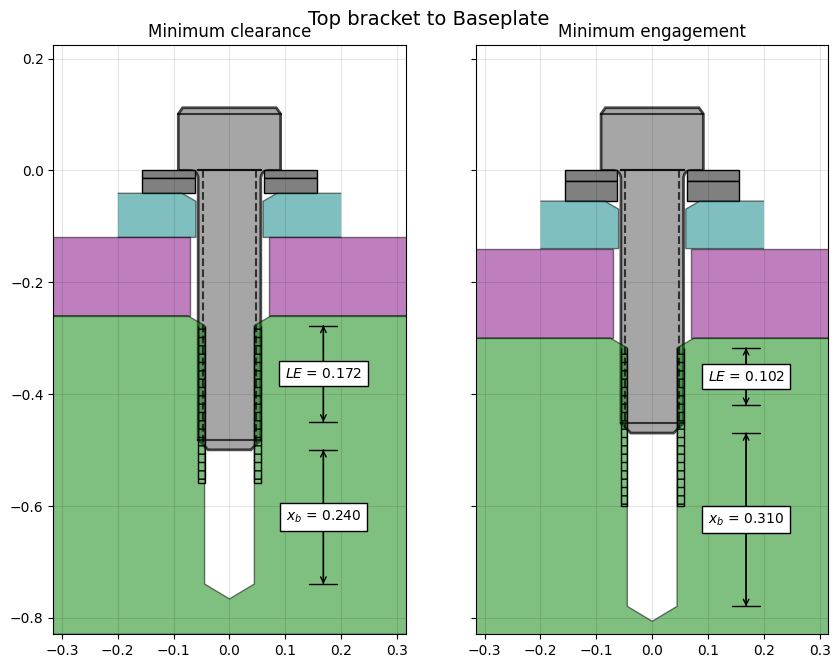

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,12), sharex=True, sharey=True)

j1000.plot(ax=ax)
# fig.savefig(r'C:\Users\austin\temp.png',bbox_inches='tight')#dpi=800)

## Plot an diagram showing components

<Axes: >

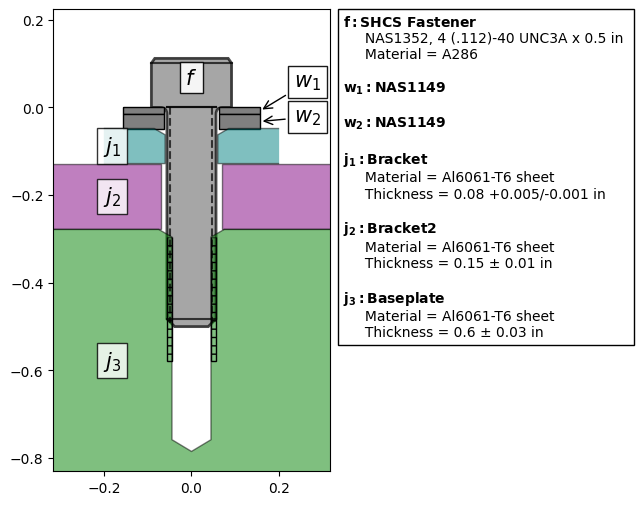

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
j1000.plot(ax=ax,kind='nom')

# fig.savefig(r'C:\Users\austin\dims.png',bbox_inches='tight',dpi=800)

## Loads 

Create some dummy loads for two load cases with different temperatures

In [5]:
lcs = ['cold','hot']
eids = [1000, 1001, 1002, 1003]

lc1 = np.ones((4,1)) * [-80., 0.]
lc2 = np.ones((4,1)) * [-0., 100.]

loads = np.random.rand(8,3) * 100.
loads_and_temp = np.concatenate((np.concatenate((lc1, lc2)), loads), axis=1)

mi = pd.MultiIndex.from_product([lcs, eids],
                           names=['case','eid'],)

# Loads with temperature in load cases
loads = pd.DataFrame(data=loads_and_temp,
                  index=mi,
                  columns=['del_T_min','del_T_max','P','V','M'])

loads

del_T_min  del_T_max          P          V          M
case eid                                                        
cold 1000      -80.0        0.0  21.391538  93.682148  57.980200
     1001      -80.0        0.0  92.996334  63.563488  35.827171
     1002      -80.0        0.0  27.019345  92.367779  34.145014
     1003      -80.0        0.0   7.904103   4.932506  24.485747
hot  1000       -0.0      100.0  23.416121  79.130898   2.497809
     1001       -0.0      100.0  63.682701  65.674822  63.058047
     1002       -0.0      100.0  26.074513  59.819700  55.748654
     1003       -0.0      100.0  81.180843  77.072221  91.281168

## Calculate margins of safety

In [6]:
df_ms = j1000.calc_margins(loads).round(3)
      
df_ms        

del_T_min  del_T_max       P       V       M  P_p_max  P_p_min  \
case eid                                                                    
cold 1000      -80.0        0.0  21.392  93.682  57.980  572.545  811.831   
     1001      -80.0        0.0  92.996  63.563  35.827  572.545  811.831   
     1002      -80.0        0.0  27.019  92.368  34.145  572.545  811.831   
     1003      -80.0        0.0   7.904   4.933  24.486  572.545  811.831   
hot  1000       -0.0      100.0  23.416  79.131   2.498  979.004  486.663   
     1001       -0.0      100.0  63.683  65.675  63.058  979.004  486.663   
     1002       -0.0      100.0  26.075  59.820  55.749  979.004  486.663   
     1003       -0.0      100.0  81.181  77.072  91.281  979.004  486.663   

           MS_sep   MS_tu   MS_su  MS_ty  MS_slip   MS_int  
case eid                                                    
cold 1000  14.826  18.619   3.224  0.797   -0.647    9.338  
     1001   2.640   3.513   5.225 -0.587   -0.535    8.440  
     1002  11.530  14.532   3.284  0.422   -0.644    9.306  
     1003  41.832  52.096  79.221  3.863    4.916  102.555  
hot  1000  13.458  16.922   4.000  0.641   -0.584   10.852  
     1001   4.316   5.590   5.025 -0.396   -0.530   10.113  
     1002  11.984  15.095   5.615  0.474   -0.458   13.732  
     1003   3.170   4.170   4.134 -0.527   -0.603    8.311

## Write out the summary report

In [7]:
report = JointReport(joint=j1000)

report.generate(r'C:\Users\austi\example', loads=loads, margin_results=df_ms)
report.compile('na')